In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely import geometry
from geopandas import GeoSeries, GeoDataFrame

# Import Data

In [3]:
#read data in from pickle file
df = pd.read_pickle('C:/Users/Stacey/Downloads/NY_complaint_data_cleaned_with_XY.pkl')

In [4]:
df.shape

(5560057, 29)

In [5]:
df.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,CMPLNT_FR_DATE,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,CAT_OFNS,BORO_PREC
0,101109527,12/31/2015,23:45:00,NaT,nan,2015-12-31,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,1007314.0,241257.0,40.828848,-73.916661,2015-12-31,2015,12,BRONX,FELONY-FORGERY,BRONX-44


# Get the precinct shapefile

In [6]:
#open the shape file from 
#https://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page
df_prec = gpd.read_file('zip://'+'nypp.zip')

In [7]:
type(df_prec)

geopandas.geodataframe.GeoDataFrame

In [8]:
df_prec.head(1)

,Precinct,Shape_Leng,Shape_Area,geometry
0,1,79979.343304,4.718208e+07,(POLYGON ((972081.7882080078 190733.4674072266...


In [9]:
#check CRS
df_prec.crs

{'datum': 'NAD83',
 'lat_0': 40.16666666666666,
 'lat_1': 40.66666666666666,
 'lat_2': 41.03333333333333,
 'lon_0': -74,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 300000,
 'y_0': 0}

(array([  900000.,   925000.,   950000.,   975000.,  1000000.,  1025000.,
         1050000.,  1075000.,  1100000.]),
 <a list of 9 Text xticklabel objects>)

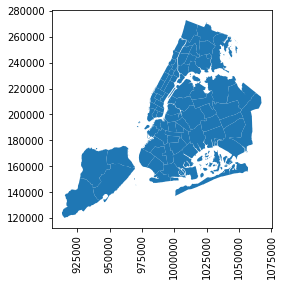

In [10]:
# view map
df_prec.plot()
plt.xticks(rotation=90)

The X,Y coordinates in the crime dataset are also NAD83 so there is no need to project to a different CRS (coordinate reference system) and units are in feet so the distance calculations are easier.

# Remove missing X_coord/Y_coord data points and missing crime types

In [11]:
#remove rows where latitude or longitude is missing
df2 = df[~( (df.X_COORD_CD.isnull()) | (df.Y_COORD_CD.isnull()) )]

In [12]:
#view number of records
df2.shape, df.shape

((5367697, 29), (5560057, 29))

In [13]:
#remove observations with null crime typee
df2 = df2[~df2.OFNS_DESC.isnull()]

In [14]:
#view number of records
df2.shape, df.shape

((5349607, 29), (5560057, 29))

# Find the centroid of the precincts

In [15]:
#set up blank lists for the x and y coordinate of the centroids
cent_x = []
cent_y = []
#get the centroid for each precinct
for index, row in df_prec.iterrows():
    x = row.geometry.centroid.x
    y = row.geometry.centroid.y
    cent_x.append(x)
    cent_y.append(y)

In [16]:
#view the lists
cent_x[0:5],cent_y[0:5]

([980907.7184392913,
  985041.1301694768,
  983590.0887902885,
  988700.437564227,
  988854.6110639743],
 [197854.98359563862,
  200285.7478161191,
  206569.38285115844,
  199930.45271963626,
  203875.07164824434])

In [17]:
#add the x and y coordinates of the centroids to the dataframe
df_prec['centroid_x'] = cent_x
df_prec['centroid_y'] = cent_y

In [18]:
df_prec.head(1)

,Precinct,Shape_Leng,Shape_Area,geometry,centroid_x,centroid_y
0,1,79979.343304,4.718208e+07,(POLYGON ((972081.7882080078 190733.4674072266...,980907.718439,197854.983596


In [19]:
#convert the x_coord and y_coord to a geometric object
df_prec['centroid_point'] = [geometry.Point(xy) for xy in zip(
    df_prec.centroid_x, df_prec.centroid_y)]

In [20]:
df_prec['centroid'] = [c for c in zip(df_prec.centroid_x, df_prec.centroid_y)]

In [21]:
df_prec.head(1)

,Precinct,Shape_Leng,Shape_Area,geometry,centroid_x,centroid_y,centroid_point,centroid
0,1,79979.343304,4.718208e+07,(POLYGON ((972081.7882080078 190733.4674072266...,980907.718439,197854.983596,POINT (980907.7184392913 197854.9835956386),"(980907.718439, 197854.983596)"


Text(0.5,1,'Precinct Map')

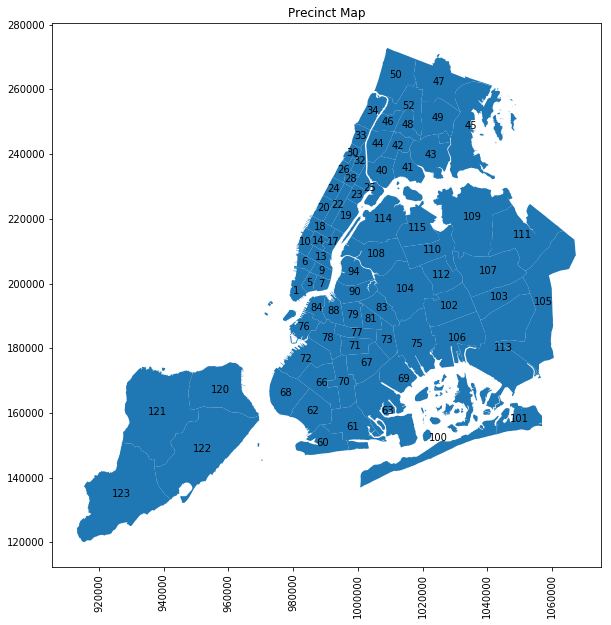

In [22]:
# view map
df_prec.plot(figsize=(15, 10))
plt.xticks(rotation=90)
for idx, row in df_prec.iterrows():
    plt.annotate(s=row['Precinct'],xy=row['centroid'],
                 horizontalalignment='center',verticalalignment='center')
plt.title('Precinct Map')

In [23]:
df2.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,CMPLNT_FR_DATE,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,CAT_OFNS,BORO_PREC
0,101109527,12/31/2015,23:45:00,NaT,nan,2015-12-31,113,FORGERY,729.0,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,1007314.0,241257.0,40.828848,-73.916661,2015-12-31,2015,12,BRONX,FELONY-FORGERY,BRONX-44


In [24]:
#supress scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Confirm coordinate systems are the same

In [25]:
#view summary stats on coordinate system of the crime dataframe
df2[['X_COORD_CD','Y_COORD_CD']].describe()

,X_COORD_CD,Y_COORD_CD
count,5349607.00,5349607.00
mean,1004648.93,206904.91
std,21454.91,30486.30
min,913319.00,120829.00
25%,991707.00,184143.00
50%,1004298.00,205561.00
75%,1016282.00,235177.00
max,1067298.00,271820.00


In [26]:
#view summary stats on coordinate system for the precinct dataframe
df_prec[['centroid_x','centroid_y']].describe()

,centroid_x,centroid_y
count,77.00,77.00
mean,1003248.20,204226.40
std,23137.11,30993.17
min,927028.43,134921.13
25%,989215.37,182718.03
50%,1000670.97,203444.65
75%,1015339.92,229141.25
max,1057214.74,264436.88


# View top Brooklyn precincts for Grand Larceny
creat heatmap

In [27]:
#get 2016, Grand Larceny, Brooklyn observations and group by precinct
df_BK_2016_GL = df2[['CMPLNT_NUM','CMPLNT_FR_DATE_YEAR',
             'PRECINCT','BORO','OFNS_DESC']][(df2.BORO=='BROOKLYN') &
                                (df2.CMPLNT_FR_DATE_YEAR == 2016) &
                                (df2.OFNS_DESC == 'GRAND LARCENY')
                                ].groupby(['CMPLNT_FR_DATE_YEAR',
                                           'PRECINCT','BORO','OFNS_DESC'
                     ],as_index=False).agg(['count'])
#reformat headers
df_BK_2016_GL.columns = ['_'.join(tup).rstrip('_') for tup in df_BK_2016_GL.columns.values]
df_BK_2016_GL.reset_index(col_level=1,inplace = True)

In [28]:
df_BK_2016_GL.head()

,CMPLNT_FR_DATE_YEAR,PRECINCT,BORO,OFNS_DESC,CMPLNT_NUM_count
0,2016,60,BROOKLYN,GRAND LARCENY,346
1,2016,61,BROOKLYN,GRAND LARCENY,532
2,2016,62,BROOKLYN,GRAND LARCENY,444
3,2016,63,BROOKLYN,GRAND LARCENY,537
4,2016,66,BROOKLYN,GRAND LARCENY,443


In [29]:
#create a dataframe with just boroughs and precincts
boro_prec = df2[['BORO','PRECINCT']].drop_duplicates().sort_values(['BORO','PRECINCT'])
print(boro_prec.shape)
boro_prec.head()

(77, 2)


,BORO,PRECINCT
140,BRONX,40
10,BRONX,41
33,BRONX,42
47,BRONX,43
0,BRONX,44


In [30]:
#add a borough column to the precinct dataframe
df_prec = df_prec.merge(boro_prec, left_on = 'Precinct',
                      right_on = 'PRECINCT', how = 'left')

In [31]:
print(df_prec.shape)
df_prec.head()

(77, 10)


,Precinct,Shape_Leng,Shape_Area,geometry,centroid_x,centroid_y,centroid_point,centroid,BORO,PRECINCT
0,1,79979.34,47182078.43,(POLYGON ((972081.7882080078 190733.4674072266...,980907.72,197854.98,POINT (980907.7184392913 197854.9835956386),"(980907.718439, 197854.983596)",MANHATTAN,1
1,5,18676.12,18088797.95,"POLYGON ((987399.2067871094 202660.9920043945,...",985041.13,200285.75,POINT (985041.1301694768 200285.7478161191),"(985041.130169, 200285.747816)",MANHATTAN,5
2,6,27182.61,22131930.52,"POLYGON ((984337.591796875 208351.1055908203, ...",983590.09,206569.38,POINT (983590.0887902885 206569.3828511584),"(983590.08879, 206569.382851)",MANHATTAN,6
3,7,17301.48,18363385.18,"POLYGON ((991608.8134155273 201215.206237793, ...",988700.44,199930.45,POINT (988700.437564227 199930.4527196363),"(988700.437564, 199930.45272)",MANHATTAN,7
4,9,19773.40,21394013.38,"POLYGON ((992119.1235961914 204042.7609863281,...",988854.61,203875.07,POINT (988854.6110639743 203875.0716482443),"(988854.611064, 203875.071648)",MANHATTAN,9


In [32]:
#subset the precinct file to just Brooklyn precincts
df_prec_BK = df_prec[df_prec.BORO == 'BROOKLYN'].copy()
print(df_prec_BK.shape)
df_prec_BK.head()

(23, 10)


,Precinct,Shape_Leng,Shape_Area,geometry,centroid_x,centroid_y,centroid_point,centroid,BORO,PRECINCT
34,60,66157.64,88169556.06,"POLYGON ((988770.7618408203 156350.5123901367,...",989215.37,150822.84,POINT (989215.373971913 150822.8415086869),"(989215.373972, 150822.841509)",BROOKLYN,60
35,61,128324.22,134635110.07,(POLYGON ((1013340.182434082 149419.9523925781...,998377.05,155782.24,POINT (998377.0454832315 155782.240974662),"(998377.045483, 155782.240975)",BROOKLYN,61
36,62,51716.70,103208535.31,"POLYGON ((991748.3936157227 161084.9552001953,...",986017.12,160503.56,POINT (986017.1170631003 160503.5562418149),"(986017.117063, 160503.556242)",BROOKLYN,62
37,63,205126.18,229441742.00,(POLYGON ((1007734.250183105 152867.5050048828...,1009238.91,160677.82,POINT (1009238.909900201 160677.8165610118),"(1009238.9099, 160677.816561)",BROOKLYN,63
38,66,52362.50,99520789.11,"POLYGON ((992187.4086303711 175455.466796875, ...",988894.73,169249.81,POINT (988894.7261110395 169249.8113268798),"(988894.726111, 169249.811327)",BROOKLYN,66


In [33]:
#merge 2016 dataframe into map dataframe
df_prec_BK_2016_GL = df_prec_BK.merge(df_BK_2016_GL, on = 'PRECINCT',
                                      how = 'left')

In [63]:
df_prec_BK_2016_GL.sort_values('CMPLNT_NUM_count',ascending=False).head()

,Precinct,Shape_Leng,Shape_Area,geometry,centroid_x,centroid_y,centroid_point,centroid,BORO_x,PRECINCT,CMPLNT_FR_DATE_YEAR,BORO_y,OFNS_DESC,CMPLNT_NUM_count
12,75,114009.99,183100917.81,(POLYGON ((1025825.841796875 166404.5057983398...,1018265.79,181367.64,POINT (1018265.789448284 181367.6417959543),"(1018265.78945, 181367.641796)",BROOKLYN,75,2016,BROOKLYN,GRAND LARCENY,985
21,90,51583.31,66154252.97,"POLYGON ((1005247.585998535 199458.5592041016,...",999046.76,197474.46,POINT (999046.7610560391 197474.4569297954),"(999046.761056, 197474.45693)",BROOKLYN,90,2016,BROOKLYN,GRAND LARCENY,681
8,70,49075.67,82181407.82,"POLYGON ((996375.2443847656 177931.2277832031,...",995597.27,169478.16,POINT (995597.2667114991 169478.1592876922),"(995597.266711, 169478.159288)",BROOKLYN,70,2016,BROOKLYN,GRAND LARCENY,620
19,84,38088.39,35462930.77,"POLYGON ((990064.3526000977 196473.115234375, ...",987327.98,192418.33,POINT (987327.9821514627 192418.3317981376),"(987327.982151, 192418.331798)",BROOKLYN,84,2016,BROOKLYN,GRAND LARCENY,569
5,67,43288.94,93744758.44,"POLYGON ((1009902.795837402 176534.5101928711,...",1002616.12,175386.43,POINT (1002616.116164477 175386.4327457748),"(1002616.11616, 175386.432746)",BROOKLYN,67,2016,BROOKLYN,GRAND LARCENY,568


Text(0.5,1,'Brooklyn 2016 Grand Larcency by Precinct')

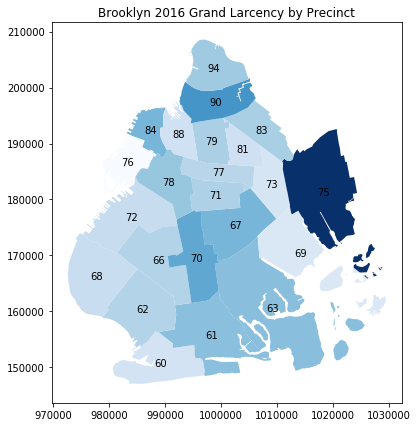

In [35]:
#plot 2016 Brooklyn Grand Larcency by precinct
df_prec_BK_2016_GL.plot(column='CMPLNT_NUM_count', cmap="Blues",figsize=(10, 7))
for idx, row in df_prec_BK_2016_GL.iterrows():
    plt.annotate(s=row['Precinct'],xy=row['centroid'],
                 horizontalalignment='center',verticalalignment='center')
plt.title('Brooklyn 2016 Grand Larcency by Precinct')


# Choose a point and a radius

Based on the data exploration Precinct 75 in Brooklyn has the highest overall crime and Grand Larceny is the most common Felony in all boroughs. The initial modeling focused on the centroid of precinct 75 and a 1/2 mile radius around that point.  Based on the map above precinct 75 also has the highest number of Grand Larcency crimes of any Brooklyn Precinct.

The model will be tested on Precinct 62 in Brooklyn, a different area of the borough both geographically and demographically, with mid-level overall crime as compared to other precincts in the city, and low to mid levels of Grand Larcency crimes.

# Consider a radius around the centroid

Get the centroid for precinct 62

In [36]:
prec_62 = df_prec[df_prec.Precinct == 62]
prec_62

,Precinct,Shape_Leng,Shape_Area,geometry,centroid_x,centroid_y,centroid_point,centroid,BORO,PRECINCT
36,62,51716.70,103208535.31,"POLYGON ((991748.3936157227 161084.9552001953,...",986017.12,160503.56,POINT (986017.1170631003 160503.5562418149),"(986017.117063, 160503.556242)",BROOKLYN,62


In [37]:
#set point P
P = geometry.Point(prec_62.centroid_x, prec_62.centroid_y)
print(P)

POINT (986017.1170631003 160503.5562418149)


In [38]:
type(P)

shapely.geometry.point.Point

In [39]:
#set radius in feet (5280 feet per mile)
R = 5280/2 #1/2 mile
R

2640.0

Set up a new dataframe for the crime data

In [40]:
#copy the dataframe
df3 = df2.copy()

In [41]:
#convert the x_coord and y_coord to a geometric object
points = [geometry.Point(xy) for xy in zip(df3.X_COORD_CD, df3.Y_COORD_CD)]

In [42]:
#add points to the dataframe
df3['points'] = points

In [43]:
#compute distance from all observed points to point P
dist = [p.distance(P) for p in points]

In [44]:
#add the distances to the dataframe
df3['distance'] = dist

In [45]:
df3.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,Latitude,Longitude,CMPLNT_FR_DATE,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,CAT_OFNS,BORO_PREC,points,distance
0,101109527,12/31/2015,23:45:00,NaT,nan,2015-12-31,113,FORGERY,729.00,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,40.83,-73.92,2015-12-31,2015,12,BRONX,FELONY-FORGERY,BRONX-44,POINT (1007314 241257),83514.53


In [46]:
#Check if each point is within radius R (1 for yes, 0 for no)
df3['R2640'] = np.where(df3.distance <= R, 1, 0)

In [47]:
#check the resulting dataframe
df3[['BORO','PRECINCT','X_COORD_CD','Y_COORD_CD','points','distance','R2640']].sort_values('distance')

,BORO,PRECINCT,X_COORD_CD,Y_COORD_CD,points,distance,R2640
3186179,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
1987583,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
1440965,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
1204447,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
4577592,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
3142953,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
1168279,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
3741001,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
4311069,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
4694576,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1


In [48]:
#check the boro and precinct for observations in the radius
df3[['BORO','PRECINCT','X_COORD_CD','Y_COORD_CD','points',
     'distance','R2640']][df3.R2640 == 1].sort_values('distance')
#Boro is always Brooklyn, Precinct is always 62

,BORO,PRECINCT,X_COORD_CD,Y_COORD_CD,points,distance,R2640
517179,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
2989920,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
4758148,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
1987583,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
4951966,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
555486,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
3463525,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
3741001,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
4927770,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1
3448207,BROOKLYN,62,986021.00,160547.00,POINT (986021 160547),43.62,1


In [49]:
#check precinct 62
df3[df3.PRECINCT == 62][['OFNS_DESC',
 'LAW_CAT_CD', 'PRECINCT', 'X_COORD_CD',
 'Y_COORD_CD', 'Latitude', 'Longitude',
 'CMPLNT_FR_DATE', 'CMPLNT_FR_DATE_YEAR',
 'CMPLNT_FR_DATE_MONTH', 'BORO', 'CAT_OFNS',
 'BORO_PREC', 'points', 'distance',
 'R2640']].sort_values('distance')

,OFNS_DESC,LAW_CAT_CD,PRECINCT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,CMPLNT_FR_DATE,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,CAT_OFNS,BORO_PREC,points,distance,R2640
1440965,ASSAULT 3 & RELATED OFFENSES,MISDEMEANOR,62,986021.00,160547.00,40.61,-73.99,2013-01-20,2013,1,BROOKLYN,MISDEMEANOR-ASSAULT 3 & RELATED OFFENSES,BROOKLYN-62,POINT (986021 160547),43.62,1
3463525,PETIT LARCENY,MISDEMEANOR,62,986021.00,160547.00,40.61,-73.99,2009-01-22,2009,1,BROOKLYN,MISDEMEANOR-PETIT LARCENY,BROOKLYN-62,POINT (986021 160547),43.62,1
2957484,CRIMINAL MISCHIEF & RELATED OF,MISDEMEANOR,62,986021.00,160547.00,40.61,-73.99,2010-01-17,2010,1,BROOKLYN,MISDEMEANOR-CRIMINAL MISCHIEF & RELATED OF,BROOKLYN-62,POINT (986021 160547),43.62,1
1168279,BURGLARY,FELONY,62,986021.00,160547.00,40.61,-73.99,2013-08-09,2013,8,BROOKLYN,FELONY-BURGLARY,BROOKLYN-62,POINT (986021 160547),43.62,1
3741001,ASSAULT 3 & RELATED OFFENSES,MISDEMEANOR,62,986021.00,160547.00,40.61,-73.99,2008-07-13,2008,7,BROOKLYN,MISDEMEANOR-ASSAULT 3 & RELATED OFFENSES,BROOKLYN-62,POINT (986021 160547),43.62,1
3186179,HARRASSMENT 2,VIOLATION,62,986021.00,160547.00,40.61,-73.99,2009-08-07,2009,8,BROOKLYN,VIOLATION-HARRASSMENT 2,BROOKLYN-62,POINT (986021 160547),43.62,1
3751677,GRAND LARCENY,FELONY,62,986021.00,160547.00,40.61,-73.99,2008-07-05,2008,7,BROOKLYN,FELONY-GRAND LARCENY,BROOKLYN-62,POINT (986021 160547),43.62,1
1335006,PETIT LARCENY,MISDEMEANOR,62,986021.00,160547.00,40.61,-73.99,2013-04-01,2013,4,BROOKLYN,MISDEMEANOR-PETIT LARCENY,BROOKLYN-62,POINT (986021 160547),43.62,1
4758148,GRAND LARCENY,FELONY,62,986021.00,160547.00,40.61,-73.99,2006-08-19,2006,8,BROOKLYN,FELONY-GRAND LARCENY,BROOKLYN-62,POINT (986021 160547),43.62,1
4927770,ASSAULT 3 & RELATED OFFENSES,MISDEMEANOR,62,986021.00,160547.00,40.61,-73.99,2006-04-30,2006,4,BROOKLYN,MISDEMEANOR-ASSAULT 3 & RELATED OFFENSES,BROOKLYN-62,POINT (986021 160547),43.62,1


# Group by month by offense type in the radius

Precinct 62 has less crime overall than precinct 75, but appears to have a large

# Evaluate additional radiuses

In [56]:
#create a function to evaluate the distance from the radius

def eval_radius(df,R,O):

    #set the column name for the new R column
    col_name = 'R' + str(int(round(R,0)))
    
    #Check if each point is within radius R (1 for yes, 0 for no)
    #Add the column to the dataframe
    df[col_name] = np.where(df.distance <= R, 1, 0)
    
    #get observations that are in the radius
    df_R = df[df[col_name] == 1]
    
    #group complaint data by year, month, borough, precinct, category, 
    #description
    df_agg = df_R[['CMPLNT_NUM','CMPLNT_FR_DATE_YEAR','CMPLNT_FR_DATE_MONTH',
                 'BORO','LAW_CAT_CD','OFNS_DESC','CAT_OFNS']
               ].groupby(['CMPLNT_FR_DATE_YEAR','CMPLNT_FR_DATE_MONTH',
                          'BORO','LAW_CAT_CD',
                          'OFNS_DESC','CAT_OFNS'],as_index=False).agg(['count'])

    #reformat headers
    df_agg.columns = ['_'.join(tup).rstrip('_') for tup in df_agg.columns.values]
    df_agg.reset_index(col_level=1,inplace = True)
    
    df_agg_O = df_agg[df_agg.OFNS_DESC == O]
    print(df_agg_O.CMPLNT_NUM_count.describe())
    
    return df_agg_O

In [57]:
# 1/2 mile radius
df_agg_O_hm = eval_radius(df3,(5280/2),'GRAND LARCENY')

count   132.00
mean     11.72
std       3.90
min       5.00
25%       9.00
50%      11.00
75%      14.00
max      22.00
Name: CMPLNT_NUM_count, dtype: float64


Although precinct 62 has far fewer Grand Larceny crimes than precinct 75, the half mile radius around the precinct 62 centroid has a similar level to the half mile radius around precinct the precinct 75 centroid.

In [58]:
df3.head(1)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,CMPLNT_FR_DATE,CMPLNT_FR_DATE_YEAR,CMPLNT_FR_DATE_MONTH,BORO,CAT_OFNS,BORO_PREC,points,distance,R2640,R5280
0,101109527,12/31/2015,23:45:00,NaT,nan,2015-12-31,113,FORGERY,729.00,"FORGERY,ETC.,UNCLASSIFIED-FELO",...,2015-12-31,2015,12,BRONX,FELONY-FORGERY,BRONX-44,POINT (1007314 241257),83514.53,0,0


In [59]:
# One mile radius
df_agg_O_1m = eval_radius(df3,5280,'GRAND LARCENY')

count   132.00
mean     37.10
std       8.44
min      16.00
25%      31.00
50%      37.00
75%      43.00
max      59.00
Name: CMPLNT_NUM_count, dtype: float64


# P,R,O for model testing
P = centroid of precinct 62 
R = 0.5 miles (2640 feet)  
O = Grand Larceny (felony with the highest incidence in all boroughs)  

In [64]:
#export modeling dataset
df_agg_O_hm.to_pickle('C:/Users/Stacey/Downloads/NY_complaint_data_for_model_prec62.pkl')